# Malignant Comment Classification

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
from collections import Counter

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

C:\Users\91981\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#loading the train data and test data

df_train=pd.read_csv("malignant_train.csv")
df_test=pd.read_csv("Malignant_test.csv")

In [3]:
#lets check train data

df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
#lets check the test data

df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Checking featurs , duplicate values and Nan values in the dataset

In [5]:
#The Features in the data set
print("\n Features in the Dataset: \n",df_train.columns)


 Features in the Dataset: 
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')


In [6]:
#checking the shape of the data set
df_train.shape

(159571, 8)

In [7]:
#checking the data dtypes
df_train.dtypes

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

In [8]:
#checking Null values
df_train.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [9]:
# checking the values counts of each features

In [10]:
cols=['malignant','highly_malignant','rude','threat','abuse','loathe']

for col in cols:
    print("Number of value counts of {} {} ".format(col,df_train[col].unique()))
    print(df_train[f'{col}'].value_counts())

Number of value counts of malignant [0 1] 
0    144277
1     15294
Name: malignant, dtype: int64
Number of value counts of highly_malignant [0 1] 
0    157976
1      1595
Name: highly_malignant, dtype: int64
Number of value counts of rude [0 1] 
0    151122
1      8449
Name: rude, dtype: int64
Number of value counts of threat [0 1] 
0    159093
1       478
Name: threat, dtype: int64
Number of value counts of abuse [0 1] 
0    151694
1      7877
Name: abuse, dtype: int64
Number of value counts of loathe [0 1] 
0    158166
1      1405
Name: loathe, dtype: int64


In [11]:
#droping the id columns from train data set because its not giving any usefull information

In [12]:
df_train.drop(['id'],axis=1,inplace=True)

In [13]:
#lets check the summary
df_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
#now we will check the average length and maximum length of comment column

In [15]:
leng=df_train.comment_text.str.len()
leng.mean(),leng.std(),leng.median()

(394.138847284281, 590.7253812496405, 205.0)

In [16]:
#lets plot the histogram on leng

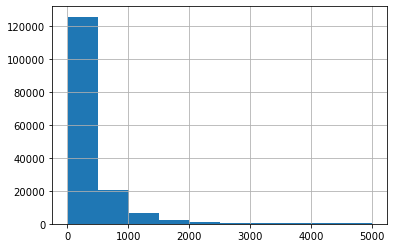

In [17]:
leng.hist()

# Checking the correlation

In [18]:
train_corr=df_train.corr()
train_corr

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


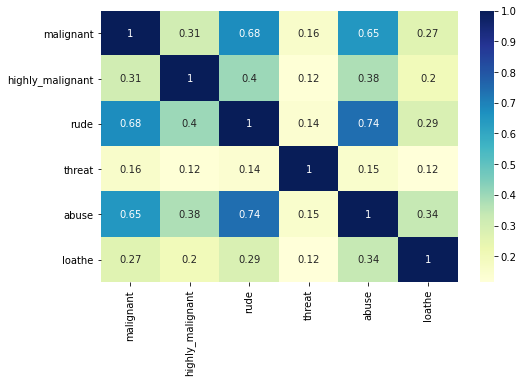

In [19]:
plt.figure(figsize=(8,5))
sns.heatmap(train_corr,annot=True,cmap='YlGnBu')
plt.show()

as we have ploted the graph here for correlation

In [20]:
# Creating a new feature having malignant and non malignant information for the particular comment.

In [21]:
labels=['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
df_train['label']=df_train[labels].max(axis=1)
df_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,label
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.101679
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
# 1 will stand for Non malignant and 0 will stand for malignant
df_train.label.value_counts()

0    143346
1     16225
Name: label, dtype: int64

In [23]:
# New feature (length) contains length of the content feature..

In [24]:
df_train['length'] = df_train.comment_text.str.len()
df_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67


In [25]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

In [26]:
#filters using POS tagging

In [27]:
def get_pos(pos_tag):
    if pos_tag.startswith('j'):
        return wordnet.ADJ
    if pos_tag.startswith('N'):
        return wordnet.NOUN
    if pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN    

Now we will create a function for data cleaning

In [28]:
def preprocessing(data):
    
    # replacing email adresss with email
    data=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', data)
    
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    data=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',data)
    
    #removing all the special characters
    data = re.sub(r'[^\w]', ' ', data)
    
    #removing all the" _ "
    data = re.sub(r'[\_]', ' ', data)
    
    #remove all the single characters left
    data=re.sub(r'\s+[a-zA-Z]\s+', ' ', data)
    
    ## Removing extra whitespaces
    data=re.sub(r'\s+', ' ', data)
    
    #converting all the letters of the review into lowercase
    data = data.lower()
    
    #splitting every words from the sentences
    data = data.split()
    
    #Removing stop words
    data=[word for word in data if not word in set(STOPWORDS)]
    
    # remove empty tokens
    data = [text for text in data if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(data)
    
    # considering words having length more than 3only
    data = [text for text in data if len(text) > 3] 
    
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    data = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]
    
    # considering words having length more than 3 only
    data = [text for text in data if len(text) > 3]
    data = ' '.join(data)
    return data    

In [29]:
#cleaning the comments and storing them into a seperate columns with name cleaned_comment

In [30]:
df_train['cleaned_comment']=df_train["comment_text"].apply(lambda x: preprocessing(x))

In [31]:
df_train["cleaned_comment"]

0         explanation edits username hardcore metallica ...
1         match background colour seemingly stuck thanks...
2         trying edit constantly removing relevant infor...
3         real suggestion improvement wondered section s...
4                                 hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                     ashamed horrible thing talk page
159568    spitzer there actual article prostitution ring...
159569       look like actually speedy version deleted look
159570    think understand came idea right away kind com...
Name: cleaned_comment, Length: 159571, dtype: object

In [32]:
# New feature (Clean_length) contains length of the cleaned_comment feature after puncuations, stopwords removal..

In [33]:
df_train['clean_len']=df_train.cleaned_comment.str.len()
df_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,cleaned_comment,clean_len
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation edits username hardcore metallica ...,128
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,match background colour seemingly stuck thanks...,64
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,trying edit constantly removing relevant infor...,112
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,real suggestion improvement wondered section s...,315
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,hero chance remember page,25


In [34]:
#Malignant Comments

In [35]:
df_train[df_train['label']==1]

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,cleaned_comment,clean_len
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1,44,cocksucker piss work,20
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1,319,talk exclusive group taliban good destroying s...,171
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1,57,look come think comming tosser,30
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,1,648,antisemmitian archangel white tiger meow greet...,312
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,1,40,fuck filthy mother,18
...,...,...,...,...,...,...,...,...,...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,1,1677,previous conversation fucking shit eating libe...,835
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,1,33,mischievious pubic hair,23
159541,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,1,346,absurd edits absurd edits great white shark to...,198
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,1,534,listen delete edits annoyed 2k15 roster confir...,199


In [36]:
#Non Malignant Comments

In [37]:
df_train[df_train['label']==0]

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,cleaned_comment,clean_len
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation edits username hardcore metallica ...,128
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,match background colour seemingly stuck thanks...,64
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,trying edit constantly removing relevant infor...,112
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,real suggestion improvement wondered section s...,315
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,hero chance remember page,25
...,...,...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0,295,second time asking view completely contradicts...,157
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0,99,ashamed horrible thing talk page,32
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0,81,spitzer there actual article prostitution ring...,61
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,0,116,look like actually speedy version deleted look,46


In [38]:
#Tokenizing the .......

In [39]:
df=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(df_train['cleaned_comment']):
    a=word_tokenize(i,'english')
    df.append(a)

In [40]:
#Makin Word dictionary with unique tokens
dictionary = corpora.Dictionary(df)
print(dictionary)

Dictionary(166192 unique tokens: ['closure', 'doll', 'edits', 'explanation', 'hardcore']...)


# Univariate

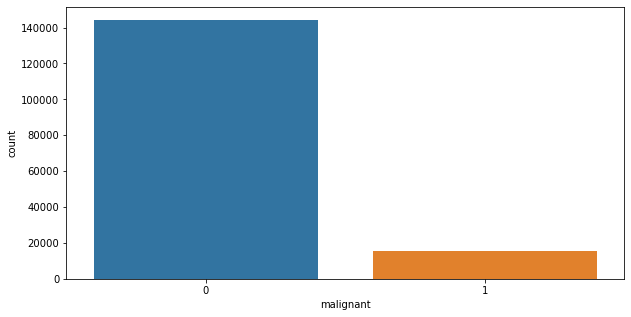

In [41]:
plt.figure(figsize=(10,5))
sns.countplot(x='malignant',data=df_train)
plt.show()

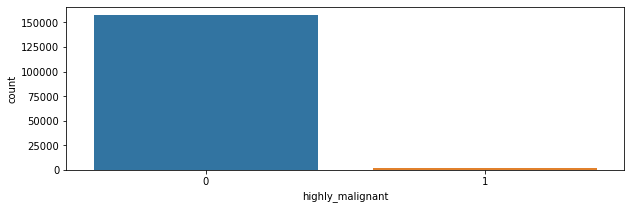

In [42]:
#lets check the 	highly_malignant
plt.figure(figsize=(10,3))
sns.countplot(x='highly_malignant',data=df_train)
plt.show()

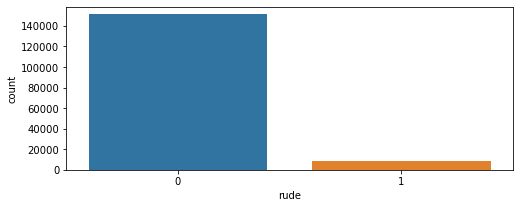

In [43]:
#lets check the rude columns
plt.figure(figsize=(8,3))
sns.countplot(x='rude',data=df_train)
plt.show()

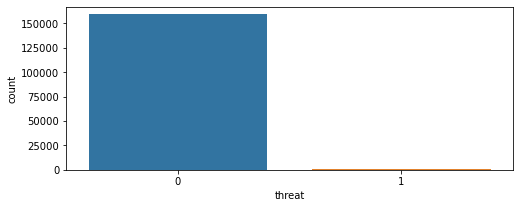

In [44]:
#lets check the threat
plt.figure(figsize=(8,3))
sns.countplot(x='threat',data=df_train)
plt.show()

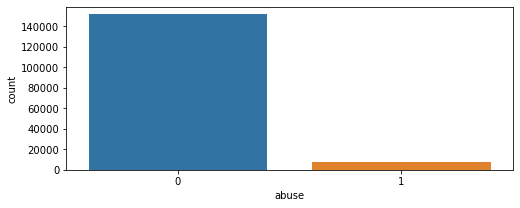

In [45]:
#lets check abuse
plt.figure(figsize=(8,3))
sns.countplot(x='abuse',data=df_train)
plt.show()

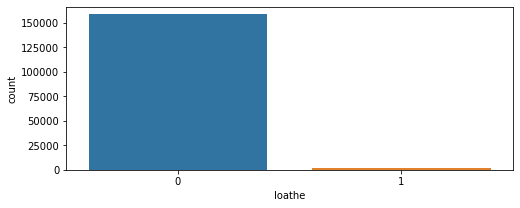

In [46]:
#lets check the loathe
plt.figure(figsize=(8,3))
sns.countplot(x='loathe',data=df_train)
plt.show()

In [47]:
# Displaying the percentage of Malignant and Not Malignant comments in the given dataset...
# Plotting graph using label values from the df_news dataframe

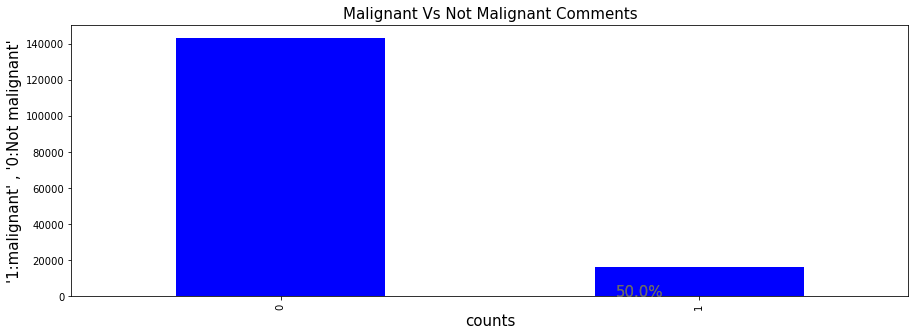

In [48]:
ax=df_train['label'].value_counts().plot(kind='bar',figsize=(15,5),color='Blue',fontsize=10)
ax.set_alpha(0.8)

#setting title and labels

ax.set_title("Malignant Vs Not Malignant Comments",fontsize=15)
ax.set_xlabel("counts",fontsize=15)
ax.set_ylabel("'1:malignant' , '0:Not malignant'",fontsize=15)

##finding the value of append list

totals=[]
for i in ax.patches:
    totals.append(i.get_width())
# set individual bar lables using above list
total = sum(totals)


# set individual bar lables using above list
# get_width pulls left or right; get_y pushes up or down
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,color='dimgrey')

In [49]:
#Lets counting frequently occurence of Malignant and not Malignant words.

In [50]:
count1=Counter(" ".join(df_train[df_train['label']==0]["cleaned_comment"]).split()).most_common(200)
count2=Counter(" ".join(df_train[df_train['label']==1]["cleaned_comment"]).split()).most_common(200)
print("TOP 200 Words in Each Category")
df=pd.DataFrame()
df['NOT Malignant Words']=count1
df['Malignant Words']=count2
df.head(10)

TOP 200 Words in Each Category


,NOT Malignant Words,Malignant Words
0,"(article, 72373)","(fuck, 10080)"
1,"(page, 54389)","(suck, 4696)"
2,"(wikipedia, 44659)","(wikipedia, 3939)"
3,"(talk, 36423)","(like, 3937)"
4,"(like, 24496)","(shit, 3708)"
5,"(source, 21267)","(nigger, 3434)"
6,"(think, 19275)","(fucking, 3337)"
7,"(time, 17844)","(page, 2870)"
8,"(know, 17690)","(hate, 2713)"
9,"(edit, 17247)","(faggot, 2707)"


In [51]:
# Making a wordcloud function in order to show the Malignant and NOT Malignant words from the dataset..

In [52]:
from wordcloud import WordCloud

In [53]:
def Word_cloud(data,title):
    cloud=WordCloud(background_color='black',max_words=2000,max_font_size=40,random_state=25).generate(str(data))
    
    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(cloud)
    plt.title(f"{title} words")
    plt.show()

In [54]:
# NOT Malignant words in training data

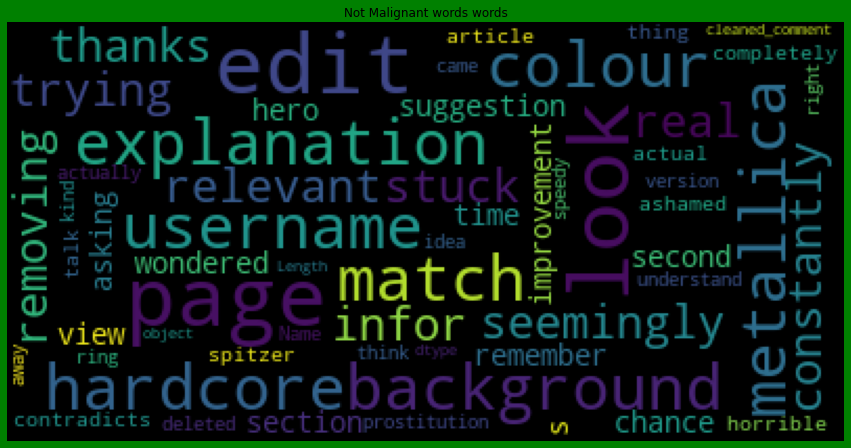

In [55]:
Word_cloud(df_train['cleaned_comment'][df_train['label']==0],"Not Malignant words")

In [56]:
df_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,cleaned_comment,clean_len
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation edits username hardcore metallica ...,128
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,match background colour seemingly stuck thanks...,64
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,trying edit constantly removing relevant infor...,112
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,real suggestion improvement wondered section s...,315
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,hero chance remember page,25


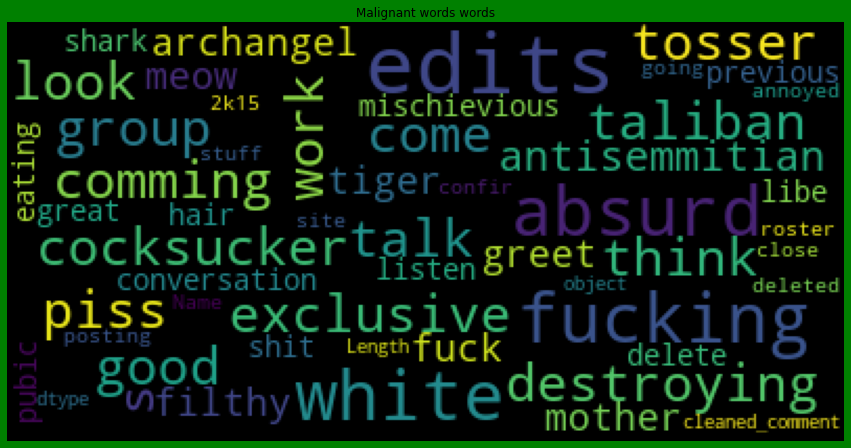

In [57]:
Word_cloud(df_train['cleaned_comment'][df_train['label']==1],"Malignant words")

In [58]:
#before cleaning the length

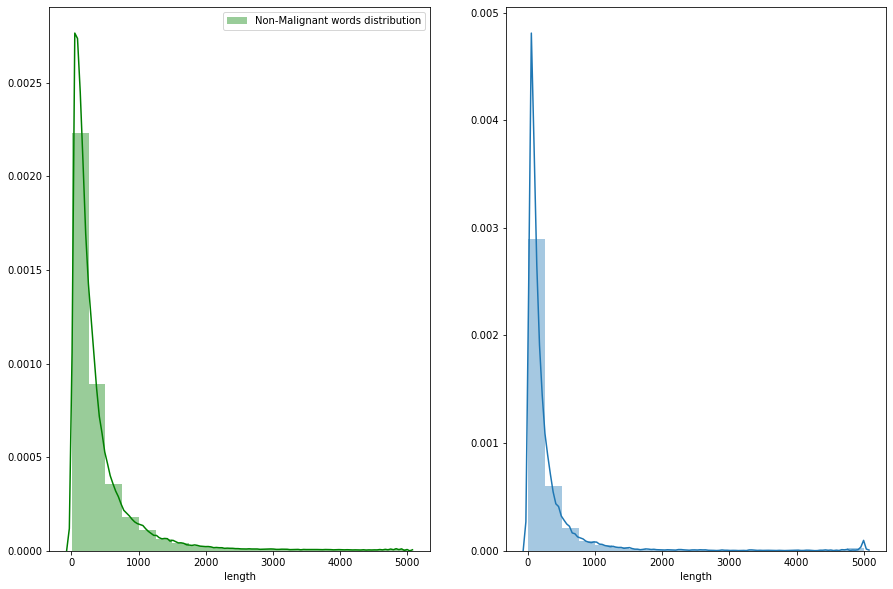

In [59]:
f,ax = plt.subplots(1,2,figsize=(15,10))

sns.distplot(df_train[df_train['label']==0]['length'],bins=20,ax=ax[0],label="Non-Malignant words distribution",color='g')

ax[0].set_label('Non-Malignant words')
ax[0].legend()

sns.distplot(df_train[df_train['label']==1]['length'],bins=20,ax=ax[1],label="Malignant word distribution")
ax[1].set_label('Malignant words')
ax[0].legend()

plt.show()

In [60]:
#After cleaning Distribution

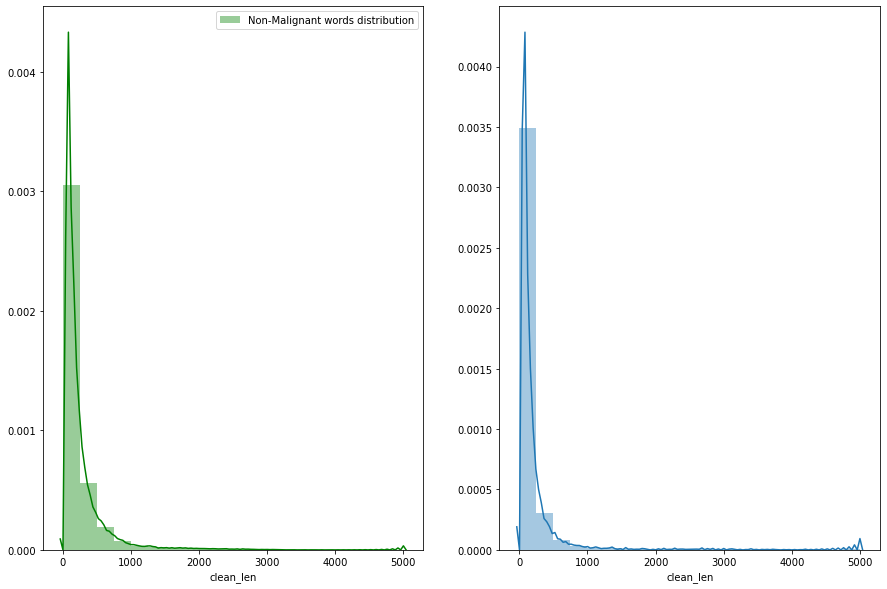

In [68]:
f,ax = plt.subplots(1,2 ,figsize=(15,10))

sns.distplot(df_train[df_train['label']==0]['clean_len'],bins=20,ax=ax[0],label="Non-Malignant words distribution",color='g')

ax[0].set_label('Non-Malignant words')
ax[0].legend()

sns.distplot(df_train[df_train['label']==1]['clean_len'],bins=20,ax=ax[1],label="Malignant word distribution")
ax[1].set_label('Malignant words')
ax[0].legend()

plt.show()

In [69]:
#creating the TfidfVectorizer 

In [70]:
def Tfidf_vectorizer(text):
    tf=TfidfVectorizer(min_df=3,smooth_idf=False)
    return tf.fit_transform(text)

In [71]:
#we will inserting the values of x variable which will be used for traing model

In [72]:
x=Tfidf_vectorizer(df_train['cleaned_comment'])
print("Shape of x: ",x.shape)

Shape of x:  (159571, 42948)


In [73]:
#Now we will Assigning the label in y variable

In [74]:
y=df_train['label'].values
print("shape of y: ",y.shape)

shape of y:  (159571,)


# Model Training

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import GridSearchCV

# Importing some metrics we can use to evaluate our model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import log_loss

In [76]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [77]:
x_train.shape

(111699, 42948)

In [78]:
x_test.shape

(47872, 42948)

In [79]:
y_train.shape

(111699,)

In [80]:
y_test.shape

(47872,)

In [81]:
#As we know that data is imbalanced and we have to balance the data 

In [82]:
from imblearn.over_sampling import SMOTE

In [ ]:
print("before over sampling the , counts of label :1 {}".format(sum(y_train==1)))
print("before over sampling the , counts of label :0 {} \n ".format(sum(y_train==0)))

sm=SMOTE(random_state=2)

x_train_res,y_train_res=sm.fit_resample(x_train,y_train.ravel())

print("After over sampling , the shape of the x_train: {}".format(x_train_res.shape))
print("After over sampling , the shape of the y_train: {} \n ".format(y_train_res.shape))

print("After over sampling , counts of label '1': {}".format(sum(y_train_res==1)))
print("After over sampling , counts of label '0': {}".format(sum(y_train_res==0)))

before over sampling the , counts of label :1 11357
before over sampling the , counts of label :0 100342 
 


In [ ]:
#lets check the Logistic score

In [ ]:
lg=LogisticRegression()
lg.fit(x_train,y_train)
lg_pred=lg.predict(x_test)
print(accuracy_score(y_test,lg_pred))
print(confusion_matrix(y_test,lg_pred))
print(classification_report(y_test,lg_pred))

In [ ]:
#lets check the MultinomialNB

In [ ]:
MNB=MultinomialNB()
MNB.fit(x_train,y_train)
mnb_pred=MNB.predict(x_test)
print(accuracy_score(y_test,mnb_pred))
print(confusion_matrix(y_test,mnb_pred))
print(classification_report(y_test,mnb_pred))

In [ ]:
#lets check the PassiveAggresiveClassifier

In [ ]:
pas=PassiveAggressiveClassifier()
pas.fit(x_train,y_train)
pac_pred=pas.predict(x_test)
print(accuracy_score(y_test,pac_pred))
print(confusion_matrix(y_test,pac_pred))
print(classification_report(y_test,pac_pred))

In [ ]:
#Lets use ensemble method random forest

In [ ]:
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
#Cross validate the model

In [ ]:
model=[LogisticRegression(),MultinomialNB(),PassiveAggressiveClassifier()]

for m in model:
    score=cross_val_score(m,x,y,cv=15,scoring='accuracy')
    print("model :",m)
    print("score :",score)
    print("mean score :",score.mean())
    print("standard deviation :",score.std())
    print("**********************************************************************************************")
    print("\n")

In [ ]:
#lets check the ROC AUC CURVE LogisticRegression

In [ ]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, lg_pred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, lg_pred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('LogisticRegression')

In [ ]:
#lets check the ROC AUC CURVE MultinomialNB

In [ ]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, mnb_pred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, mnb_pred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('MultinomialNB')

In [ ]:
#lets check the ROC AUC CURVE PassiveAggressiveClassifier

In [ ]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, pac_pred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, pac_pred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('PassiveAggressiveClassifier')

In [ ]:
#lets check the ROC AUC CURVE RandomForestClassifier

In [ ]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, y_pred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('RandomForestClassifier')

In [ ]:
#Lets check the Log_loss and hamming loss

In [ ]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss

def evaluate_score(Y_test,pred): 
    loss = hamming_loss(Y_test,pred)
    print("Hamming_loss : {}".format(loss*100))
    try : 
        loss = log_loss(Y_test,pred)
    except :
        loss = log_loss(Y_test,pred.toarray())
    print("Log_loss : {}".format(loss))

In [ ]:
evaluate_score(y_test,lg_pred)

# here we can see that Logistic Regression has given a best score after evaluating

In [ ]:
#using LogisticRegression for the final model

In [ ]:
lg=LogisticRegression()
lg.fit(x_train,y_train)
lg.score(x_train,y_train)
lg_pred=lg.predict(x_test)
print("Accuracy_Score :",accuracy_score(y_test,lg_pred))
print("confusion_matrix :",confusion_matrix(y_test,lg_pred))
print("classification_report :",classification_report(y_test,lg_pred))
print("Log Loss :",log_loss(y_test,lg_pred))

In [ ]:
# Confusion matrix Visualization
cm=confusion_matrix(y_test,lg_pred)
sns.heatmap(cm,annot=True,cbar=False,cmap='coolwarm')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("confusion matrix of GuassianNB")
plt.show()

# Test data

In [ ]:
df_test.head()

In [ ]:
#lets check the null values in text data

In [ ]:
df_test.isnull().sum()

In [ ]:
#lets convert all the data into lower case

In [ ]:
df_test['comment_text']=df_test['comment_text'].str.lower()

In [ ]:
df_test.head()

In [ ]:
#lets remove the id columns because which will not give any information

In [ ]:
df_test.drop(['id'],axis=1,inplace=True)

In [ ]:
df_test.head()

In [ ]:
#lets checck the length of the comment before cleaning it

In [ ]:
df_test['len']=df_test.comment_text.str.len()
df_test.head()

In [ ]:
#Lets Remove the punctuations

In [ ]:
# Replace email addresses with 'email'
df_test['comment_text']=df_test['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
df_test['comment_text']=df_test['comment_text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df_test['comment_text']=df_test['comment_text'].str.replace(r'£|\$', 'dollers')

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df_test['comment_text']=df_test['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')

# Replace numbers with 'numbr'
df_test['comment_text']=df_test['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [ ]:
# Remove punctuation
df_test['comment_text'] = df_test['comment_text'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df_test['comment_text'] = df_test['comment_text'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df_test['comment_text']= df_test['comment_text'].str.replace(r'^\s+|\s+?$', '')

In [ ]:
#Treating stopwords

In [ ]:
def Tfidf_vectorizer(text):
    tfid = TfidfVectorizer(max_features=43194,smooth_idf=False)
    return tfid.fit_transform(text)

In [ ]:
# cleaning the news and storing them in a separate feature...

df_test["clean_comment_text"] = df_test["comment_text"].apply(lambda x: preprocessing(x))

# Inserting vectorized values in a variable x, which will be used in training the model 
x_data=Tfidf_vectorizer(df_test['clean_comment_text'])

In [ ]:
x_data

In [ ]:
df_test

In [ ]:
#saving the model

In [ ]:
import joblib

In [ ]:
model=joblib.dump(lg,'malignant_comment_classifier.pkl')
model

In [ ]:
# Saving the Predicted values in csv file
df_test.to_csv('Malignant_Comment_Classifier_Predict.csv')